# Heat illnesses during European and World Championships in Athletics

Notebook that visualises the number of various heat-related illnesses against different daily heat indices based on the Universal Thermal Climate Index (UTCI).


Ignore this:

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## 1. Load the data

In [2]:
# IMPORT PACKAGES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

path = "/Users/milan/git/AthleticsChampionshipsHeat/data/"

DF = pd.read_excel(path+"IllnessesHeat.xlsx")

def ABC2index(S):
    i=0
    for j,s in enumerate(list(S)):
        i += j*26+(ord(s)-65)
    
    return i

In [9]:
# LOAD HEAT ILLNESS DATA
n_heatillness = DF.values[:,ABC2index("O")].astype(np.float)  # number of all heat associated illnesses
n_heatillnsev = DF.values[:,ABC2index("T")].astype(np.float)  # number of severe heat illnesses
n_dehydration = DF.values[:,ABC2index("Y")].astype(np.float)  # number of dehydration
n_others      = DF.values[:,ABC2index("AD")].astype(np.float)  # number of other illnesses

di_heatillness = DF.values[:,ABC2index("AI")].astype(np.float)  # daily incidences of above
di_heatillnsev = DF.values[:,ABC2index("AN")].astype(np.float)
di_dehydration = DF.values[:,ABC2index("AS")].astype(np.float)
di_others      = DF.values[:,ABC2index("AX")].astype(np.float)
di_all         = DF.values[:,ABC2index("N")].astype(np.float) / DF.values[:,ABC2index("E")].astype(np.float) * 1000

ill_long_names = ["Number of all heat associated illnesses",
                    "Number of severe heat illnesses",
                    "Number of dehydration",
                    "Number of other illnesses",
                    "Daily incidences of heat associated illnesses",
                    "Daily incidences of severe heat illnesses",
                    "Daily incidences of dehydration",
                    "Daily incidences of other heat illnesses",
                    "Daily incidences of all illnesses"]

In [10]:
# LOAD UTCI DATA
UTCImax = np.zeros((len(n_heatillness),3))    # time x (expected, min, max)
UTCImean = np.zeros((len(n_heatillness),3))
UTCI3day = np.zeros((len(n_heatillness),3))
UTCIdiff = np.zeros((len(n_heatillness),3))

events = ["berlin2009","daegu2011","helsinki2012", "moscow2013","zuerich2014",
          "amsterdam2016","berlin2018"]
events_long = ["Berlin 2009","Daegu 2011","Helsinki 2012","Moscow 2013","Zürich 2014",
        "Amsterdam 2016", "Berlin 2018"]
nevents = len(events)
ndays_per_event = [0,]*nevents

i = 0
for ifile,file in enumerate(events):
    # expected
    ma = np.load(path+file+"utci_daily.npz")["UTCI_dailymax"]
    me = np.load(path+file+"utci_daily.npz")["UTCI_dailymean"]
    td = np.load(path+file+"utci_daily.npz")["UTCI_3daymean"]
    di = np.load(path+file+"utci_daily.npz")["UTCI_dailydiff"]
    
    n = len(ma)
    ndays_per_event[ifile] = n
    
    UTCImax[i:i+n,0] = ma
    UTCImean[i:i+n,0] = me
    UTCI3day[i:i+n,0] = td
    UTCIdiff[i:i+n,0] = di
    
    # uncertainty - minimum
    ma = np.load(path+file+"utci_daily.npz")["UTCI_dailymax0"]
    me = np.load(path+file+"utci_daily.npz")["UTCI_dailymean0"]
    td = np.load(path+file+"utci_daily.npz")["UTCI_3daymean0"]
    di = np.load(path+file+"utci_daily.npz")["UTCI_dailydiff0"]
    
    UTCImax[i:i+n,1] = ma
    UTCImean[i:i+n,1] = me
    UTCI3day[i:i+n,1] = td
    UTCIdiff[i:i+n,1] = di
    
    # uncertainty - maximum
    ma = np.load(path+file+"utci_daily.npz")["UTCI_dailymax1"]
    me = np.load(path+file+"utci_daily.npz")["UTCI_dailymean1"]
    td = np.load(path+file+"utci_daily.npz")["UTCI_3daymean1"]
    di = np.load(path+file+"utci_daily.npz")["UTCI_dailydiff1"]
    
    UTCImax[i:i+n,2] = ma
    UTCImean[i:i+n,2] = me
    UTCI3day[i:i+n,2] = td
    UTCIdiff[i:i+n,2] = di
    
    i += n

nidxs = np.concatenate([[0],np.cumsum(ndays_per_event)])

## 2. Plot the data

In the following circles denote the respective UTCI-value as close to the stadium as possible. As there is some uncertainty from the climate data as well as in the whereabouts of the athletets, we estimate the uncertainty in the UTCI-values from the range of values within about 25km from the stadium. For Helsinki and Amsterdam, as both stadiums are in the vicinity of water bodies (which can have a large impact on the felt temperature), this yields larger uncertainties than for e.g. Moscow or Berlin. The minimum and maximum of this range is plottet as thin lines.

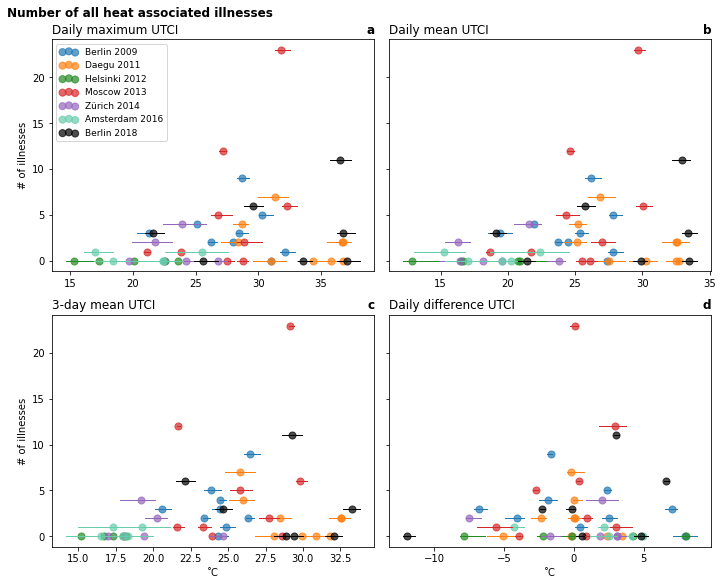

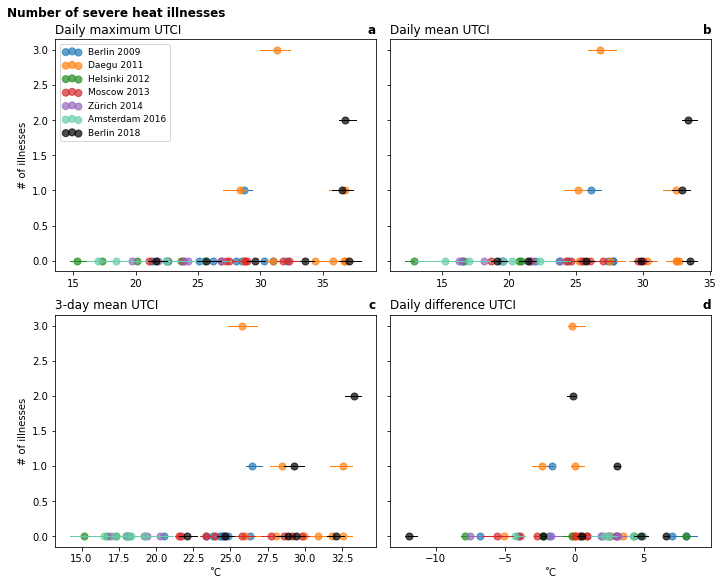

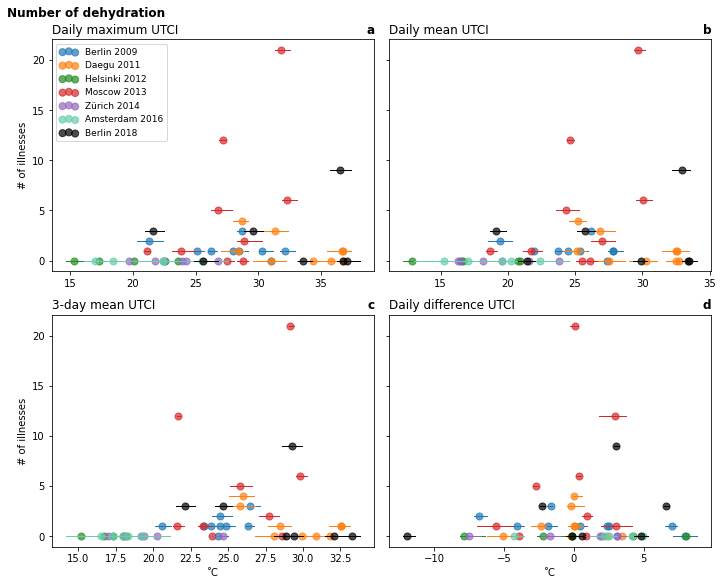

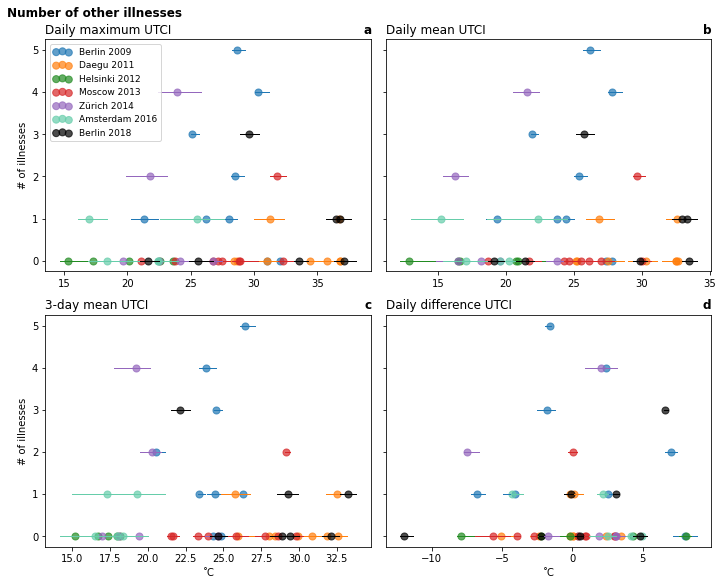

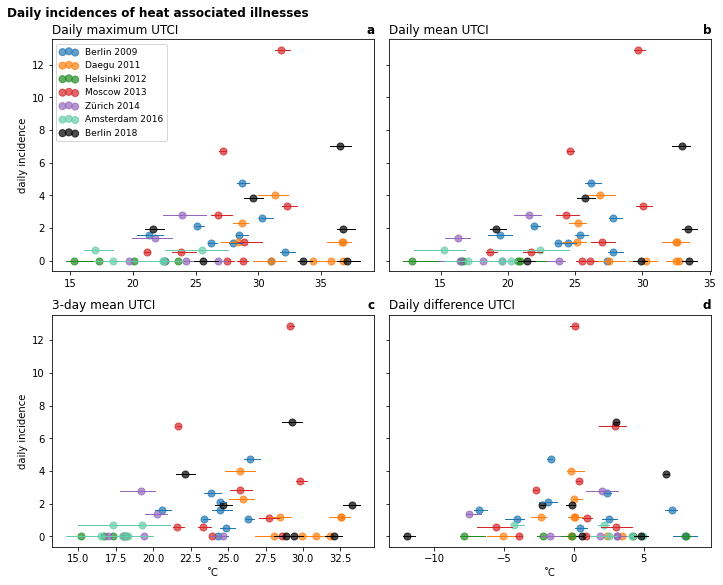

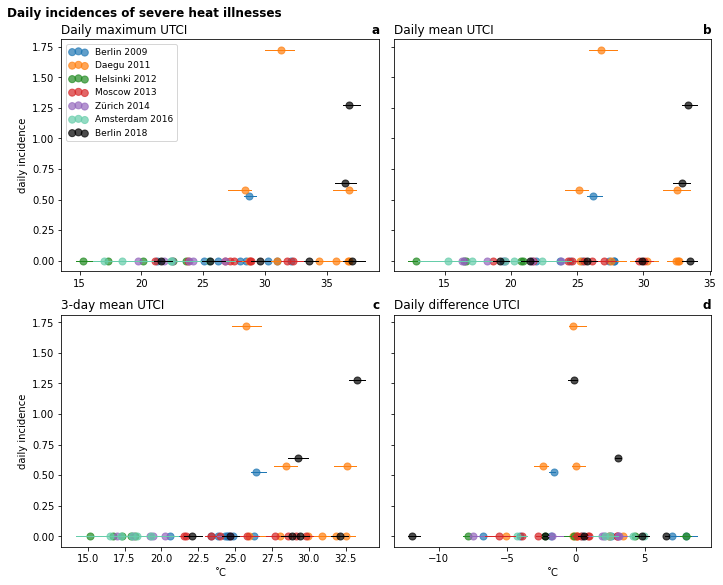

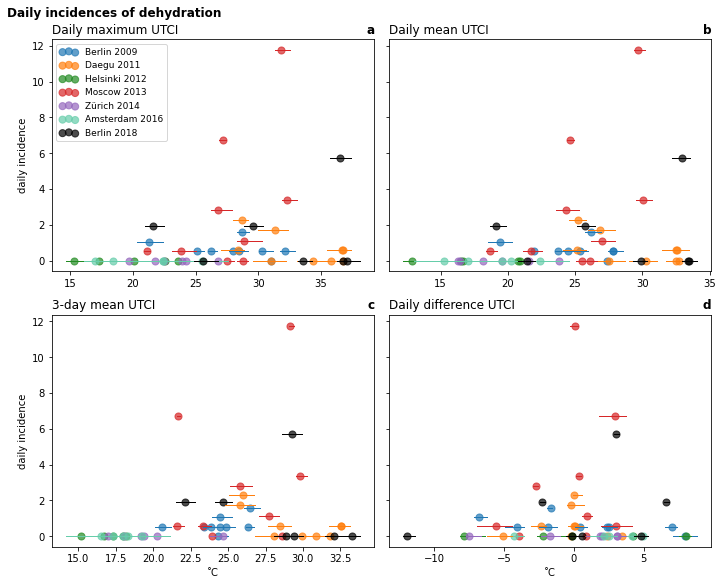

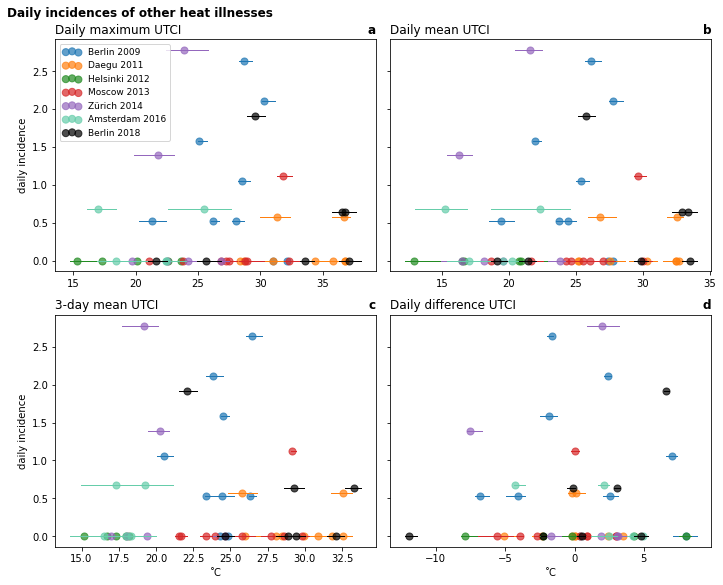

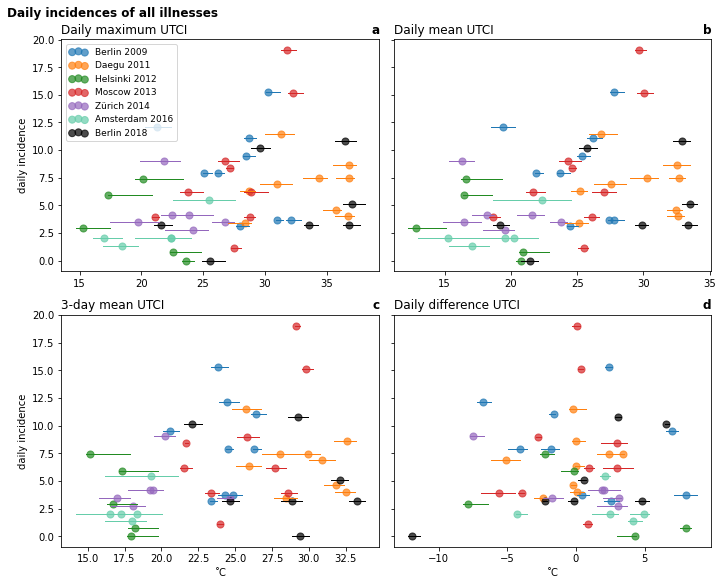

In [11]:
# PLOTTING
colours = ["C0","C1","forestgreen","C3","C4","mediumaquamarine","k"]
ylabels = ["# of illnesses",]*4+["daily incidence",]*5

for i_ill,ill in enumerate([n_heatillness,n_heatillnsev,n_dehydration,n_others,
                            di_heatillness,di_heatillnsev,di_dehydration,di_others,
                            di_all]):

    fig,axs = plt.subplots(2,2,sharey=True,figsize=(10,8))
    alfa=0.7
    lws=1.0

    # scatterpoints for expected
    for i in range(nevents):
        j0,j1 = nidxs[i],nidxs[i+1]
        axs[0,0].scatter(UTCImax[j0:j1,0],ill[j0:j1],50,color=colours[i],alpha=alfa,label=events_long[i])
        axs[0,1].scatter(UTCImean[j0:j1,0],ill[j0:j1],50,color=colours[i],alpha=alfa)
        axs[1,0].scatter(UTCI3day[j0:j1,0],ill[j0:j1],50,color=colours[i],alpha=alfa)
        axs[1,1].scatter(UTCIdiff[j0:j1,0],ill[j0:j1],50,color=colours[i],alpha=alfa)

    # lines for uncertainty
    for i in range(nevents):
        j0,j1 = nidxs[i],nidxs[i+1]
        axs[0,0].plot(UTCImax[j0:j1,1:].T,np.array([ill[j0:j1]]*2),colours[i],lw=lws)
        axs[0,1].plot(UTCImean[j0:j1,1:].T,np.array([ill[j0:j1]]*2),colours[i],lw=lws)
        axs[1,0].plot(UTCI3day[j0:j1,1:].T,np.array([ill[j0:j1]]*2),colours[i],lw=lws)
        axs[1,1].plot(UTCIdiff[j0:j1,1:].T,np.array([ill[j0:j1]]*2),colours[i],lw=lws)

    axs[0,0].set_title("Daily maximum UTCI",loc="left")
    axs[0,1].set_title("Daily mean UTCI",loc="left")
    axs[1,0].set_title("3-day mean UTCI",loc="left")
    axs[1,1].set_title("Daily difference UTCI",loc="left")

    axs[0,0].set_title("a",loc="right",fontweight="bold")
    axs[0,1].set_title("b",loc="right",fontweight="bold")
    axs[1,0].set_title("c",loc="right",fontweight="bold")
    axs[1,1].set_title("d",loc="right",fontweight="bold")

    axs[1,0].set_xlabel("˚C")
    axs[1,1].set_xlabel("˚C")

    axs[0,0].set_ylabel(ylabels[i_ill])
    axs[1,0].set_ylabel(ylabels[i_ill])

    axs[0,0].legend(loc=2,ncol=1,fontsize=9,scatterpoints=3)
    plt.suptitle(ill_long_names[i_ill],x=0,y=1.01,ha="left",fontweight="bold")
    plt.tight_layout()
    
    plt.show()